In [94]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
layer_names = []
block_l_names = ["conv0", "conv1", "shortcut"]
num_layers=27
for l in range(num_layers):
    if l%3 ==2:
        if l//3 == 3 or l//3==6:
            layer_names.append(f"Block_{l//3}_{block_l_names[l%3]}")
    else:
        layer_names.append(f"Block_{l//3}_{block_l_names[l%3]}")
api = wandb.Api()
project= "QSL2Abl"
# Project is specified by <entity/project-name>
result_list = []
config_list = []
runs = api.runs(f"alelab/{project}")
for run in runs:
    if run.state=="finished" and "old" not in run.tags: 
        config = {}
        config["bit_width_list"] = list(map(int, run.config["bit_width_list"].split(',')))
        config["bit_width"] = config["bit_width_list"][0]
        config["seed"] = run.config["seed"]
        config["epsilonlw"] = run.config["epsilonlw"]
        for l in layer_names:
            for split in ["train", "val"]:
                slack_key = f'slack_{l}_bw_{config["bit_width"]}_{split}'
                dual_key = f'dual_{l}_bw_{config["bit_width"]}'
                short_name = "".join(l.split("_")[1:])
                result_dict = {"slack": run.summary[slack_key], "layer": short_name, "split":split, "dual": run.summary[dual_key]}
                result_list.append(result_dict)
                config_list.append(config)
config_df = pd.DataFrame.from_records(config_list) 
result_df = pd.DataFrame.from_records(result_list) 
all_df = pd.concat([config_df,result_df], axis=1)

In [76]:
all_df

,bit_width_list,bit_width,seed,epsilonlw,slack,layer,split,dual
0,"[4, 32]",4,1,0.50,-0.412414,0conv0,train,0.0
1,"[4, 32]",4,1,0.50,-0.412596,0conv0,val,0.0
2,"[4, 32]",4,1,0.50,-0.499170,0conv1,train,0.0
3,"[4, 32]",4,1,0.50,-0.499169,0conv1,val,0.0
4,"[4, 32]",4,1,0.50,-0.441789,1conv0,train,0.0
...,...,...,...,...,...,...,...,...
1595,"[1, 32]",1,0,0.25,-0.147261,7conv1,val,0.0
1596,"[1, 32]",1,0,0.25,-0.103646,8conv0,train,0.0
1597,"[1, 32]",1,0,0.25,-0.104081,8conv0,val,0.0
1598,"[1, 32]",1,0,0.25,-0.166564,8conv1,train,0.0


In [77]:
short_to_long_name = {"".join(l.split("_")[1:]):l for l in layer_names}

In [78]:
short_to_long_name

{'0conv0': 'Block_0_conv0',
 '0conv1': 'Block_0_conv1',
 '1conv0': 'Block_1_conv0',
 '1conv1': 'Block_1_conv1',
 '2conv0': 'Block_2_conv0',
 '2conv1': 'Block_2_conv1',
 '3conv0': 'Block_3_conv0',
 '3conv1': 'Block_3_conv1',
 '3shortcut': 'Block_3_shortcut',
 '4conv0': 'Block_4_conv0',
 '4conv1': 'Block_4_conv1',
 '5conv0': 'Block_5_conv0',
 '5conv1': 'Block_5_conv1',
 '6conv0': 'Block_6_conv0',
 '6conv1': 'Block_6_conv1',
 '6shortcut': 'Block_6_shortcut',
 '7conv0': 'Block_7_conv0',
 '7conv1': 'Block_7_conv1',
 '8conv0': 'Block_8_conv0',
 '8conv1': 'Block_8_conv1'}

In [102]:
def make_bash(layers_no_quant="", bitwidth=2, epsilon=0.7, tag="best"):
    return f'''#!/bin/bash
            for seed in 0 1 2
            do
                curr_dir="."
                train_id="{len(layers_no_quant)}l_{tag}d_{bitwidth}_${{seed}}"
                result_dir="./results/$train_id"
                mkdir -p $result_dir
                python -u train_pd_layers_selec.py \\
                    --model resnet20q \\
                    --dataset cifar10 \\
                    --train_split train \\
                    --lr 0.001 \\
                    --lr_decay "50,75,90" \\
                    --epochs 100 \\
                    --optimizer adam \\
                    --weight-decay 0.0 \\
                    --results-dir $result_dir \\
                    --bit_width_list "{bitwidth}" \\
                    --no_quant_layer "{layers_no_quant}" \\
                    --seed "${{seed}}" \\
                    --wandb_log \\
                    --epsilonlw 0.7 \\
                    --project QSLayerRetrain
            done
            '''
        

In [103]:
import os
bash_folder = "../scripts/layer_selection/" 
epsilon = {2: 0.7, 1:0.9}
for split in ["train"]:
    for bw in [2]:
        print("bitwidth", bw)
        query_df = all_df.query(f'bit_width=={bw} and split=="{split}" and epsilonlw<0.03')
        query_df = query_df[["layer", "dual"]].groupby(['layer'], as_index=False).mean()
        query_df = query_df.sort_values("dual")
        sns.scatterplot(x ="layer", y="dual", data=query_df)
        plt.xticks(rotation=90)
        plt.show()
        for num_l in [1, 2, 8]:
            names = [short_to_long_name[name] for name in query_df['layer'][:num_l]]
            layer_no_quant = ",".join(names)
            bash = make_bash(layers_no_quant="", bitwidth=bw, epsilon=epsilon[bw], tag="worst")
            file_name = "worst_{num_l}_bw_{bw}.sh"
            with open(os.join(bash_folder, file_name), "r") as f:
                f.write(bash)
            names = [short_to_long_name[name] for name in query_df['layer'][-num_l:]]
            layer_no_quant = ",".join(names)
            bash = make_bash(layers_no_quant="", bitwidth=bw, epsilon=epsilon[bw], tag="best")
            file_name = "worst_{num_l}_bw_{bw}.sh"
            with open(os.join(bash_folder, file_name), "r") as f:
                f.write(bash)
        

SyntaxError: invalid syntax (1493343409.py, line 18)

bitwidth 1
Block_8_conv1,Block_7_conv1,Block_5_conv1,Block_3_conv1
Block_2_conv1,Block_4_conv1,Block_1_conv1,Block_8_conv0
Block_6_conv1,Block_0_conv1,Block_5_conv0,Block_7_conv0
Block_2_conv0,Block_6_conv0,Block_4_conv0,Block_3_conv0
Block_1_conv0,Block_0_conv0,Block_6_shortcut,Block_3_shortcut
worst
Block_8_conv1,Block_7_conv1,Block_5_conv1,Block_3_conv1,Block_2_conv1


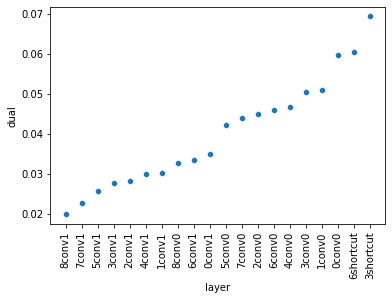

In [91]:
for split in ["train"]:
    for bw in [1]:
        print("bitwidth", bw)
        query_df = all_df.query(f'bit_width=={bw} and split=="{split}" and epsilonlw<0.03')
        query_df = query_df[["layer", "dual"]].groupby(['layer'], as_index=False).mean()
        query_df = query_df.sort_values("dual")
        for i in range(5):
            names = [short_to_long_name[name] for name in query_df['layer'][4*i:+4*(i+1)]]
            print(",".join(names))
        print("worst")
        names = [short_to_long_name[name] for name in query_df["layer"][:5]]
        print(",".join(names))
        sns.scatterplot(x ="layer", y="dual", data=query_df)
        plt.xticks(rotation=90)
        plt.show()

In [52]:
split="train"
bw=2
for seed in [0, 1, 2]:
    print(seed)
    query_df = all_df.query(f'bit_width=={bw} and split=="{split}" and project=="Blines"')
    print(query_df.sort_values("slack", ascending=False).drop_duplicates("layer")["layer"])

0


UndefinedVariableError: name 'bit_width' is not defined

In [27]:
split="train"
bw=2
for algorithm in ["OURS(high)", "OURS(low)"]:
    print(algorithm)
    for seed in [0, 1, 2]:
        print(seed)
        query_df = all_df.query(f'bit_width=={bw} and split=="{split}" and project=="LayerSelection" and algorithm=="{algorithm}"')
        print(query_df.sort_values("dual", ascending=False).drop_duplicates("layer")["layer"])

OURS(high)
0
380     9
244     7
246     8
238     4
374     6
240     5
368     3
234     2
364     1
142     0
250    10
Name: layer, dtype: int64
1
380     9
244     7
246     8
238     4
374     6
240     5
368     3
234     2
364     1
142     0
250    10
Name: layer, dtype: int64
2
380     9
244     7
246     8
238     4
374     6
240     5
368     3
234     2
364     1
142     0
250    10
Name: layer, dtype: int64
OURS(low)
0
266     7
334     8
194     4
336     9
330     6
196     5
324     3
322     2
188     1
186     0
272    10
Name: layer, dtype: int64
1
266     7
334     8
194     4
336     9
330     6
196     5
324     3
322     2
188     1
186     0
272    10
Name: layer, dtype: int64
2
266     7
334     8
194     4
336     9
330     6
196     5
324     3
322     2
188     1
186     0
272    10
Name: layer, dtype: int64
